# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучим датасет

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('C:/Users/Xiaomi/Desktop/Oleg/Docs/Практикум/3 спринт Исследовательский анализ/real_estate_data.csv', sep="\t", decimal='.')
                   
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


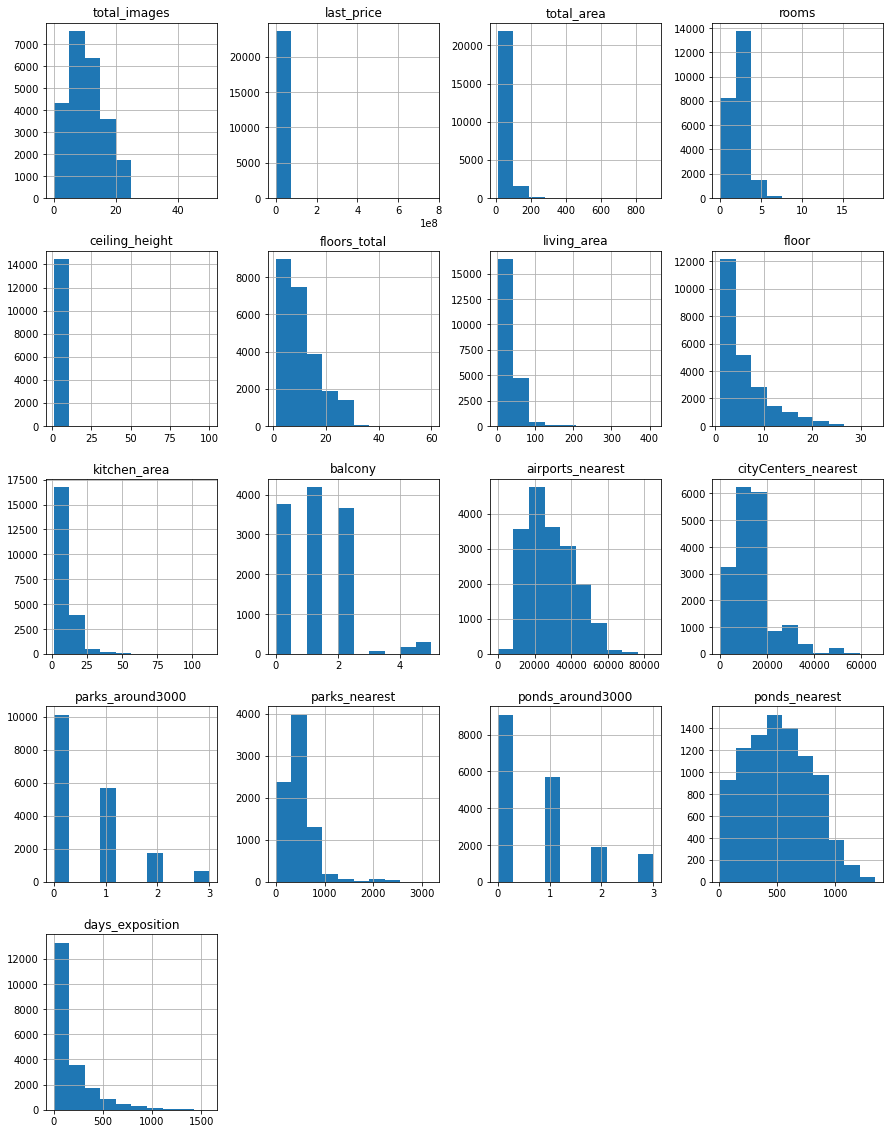

In [4]:
data.hist(figsize=(15, 20));

Данные нуждаются в предобработке, т.к. из 21 столбца в 14 есть пропуски. Столбец cityCenters_nearest прописан не в змеином регистре. Столбец с датой нуждается в форматировании to_datetime, также желательно поменять формат некоторых столбцов с float на int, например, в столбцах floors_total, balcony, где значение не должно быть дробным.
По гистограммам можно сделать промежуточный вывод о наличии выбросов в столбцах last_price, total_area, rooms, ceiling_height, living_area, kitchen_area.

### Предобработка данных

In [5]:
#приведение заголовка к змеиному регистру
data = data.rename(columns = {'cityCenters_nearest': 'city_centers_nearest'})

#### Заполнение пропусков

In [6]:
#пропуски в is_apartment заполняю на False, кол-во балконов на 0, т.к. вероятнее всего значение равно нулю и пропущено намеренно
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0)

#пропущенное кол-во этажей заполняю этажом объекта
data['floors_total'] = data['floors_total'].fillna(data['floor'])

#жилую площадь и площадь кухни заполняю средним отношением жилой площади / кухни к общей площади объекта
data['living_area'] = data['living_area'].fillna((data['living_area'] / data['total_area']).mean() * data['total_area'])
data['kitchen_area'] = data['kitchen_area'].fillna((data['kitchen_area'] / data['total_area']).mean() * data['total_area'])

#пропущенные населенные пункты заполняю unknown
data['locality_name'] = data['locality_name'].fillna('unknown')

Пропуски стоят в столбцах, необязательных к заполнению, например, ceiling_height, скорее всего данные не были внесены самими продавцами квартир. Заполнение их любым значением может исказить данные, поэтому оставляю пропуски.

Пропуски в airports_nearest, city_centers_nearest, parks_around3000, ponds_around3000, ponds_nearest по большей части стоят в маленьких населенных пунктах, за пределами больших городов. Скорее всего их заполнение автоматическое, но работает только для объектов недвижимости в крупных городах, где эти параметры имеют большое значение. Заполнение их нулем может исказить данные, поэтому эти значения оставлю пропущенными. Пропуски в parks_nearest стоят скорее всего в квартирах, в пешей доступности от которых нет парков.

Пропуск в столбце days_exposition возможно вызван ошибками выгрузки. Заполнение пропусков нулем, единицей, средним/медианой здесь также может исказить анализ и подтолкнуть к неверным выводам, поэтому оставляю эти пропуски.

#### Устранение дубликатов

In [7]:
#проверяю наличие явных дубликатов
data.duplicated().sum()

0

In [8]:
#проверяю неявные дубликаты в столбце locality_name
sorted(data['locality_name'].unique())

['unknown',
 'Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское

In [9]:
#подсчет уникальных значений
len(data['locality_name'].unique())

365

In [10]:
#убираю неявные дубликаты в столбце locality_name

data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'городской поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции', 'поселок станции')

#подсчет уникальных значений, чтобы сразу видеть результат replace
len(data['locality_name'].unique())

322

#### Изменение типов данных

In [11]:
#изменение типа данных с float на int в столбцах, где могут быть только целые значения - floors_total и balcony
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')

#преобразую даты в редактируемый формат методом to_datetime()
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S'
)

Количество этажей и балконов может быть только целым числом, поэтому данные в этих столбцах преобразовал в int.
Даты преобразовал в datetime, чтобы иметь возможность применять к датам методы pandas

#### Обработка аномальных значений

'Высота потолков'

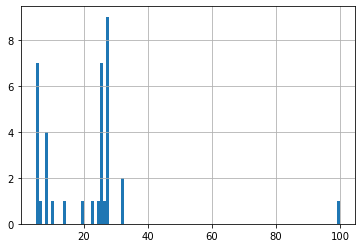

In [12]:
data['ceiling_height'].hist(bins=100, range=(5, 100))
'Высота потолков'

На гистограмме видно, что есть квартиры с высотой потолков больше 20 м и даже 100 м. Возможно, в этих данных есть лишний ноль и реальная высота не 100, а 10 м. Также есть 3 квартиры с высотой потолков меньше 1.8 м. Приведем эти аномалии к более реалистичным значениям

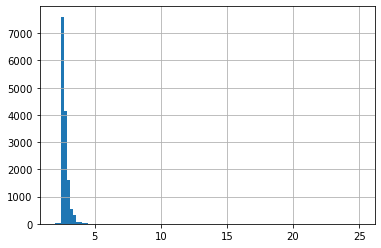

In [13]:
#data = data.query('20 > ceiling_height > 1.8')
data.loc[data['ceiling_height'] < 1.8, 'ceiling_height'] = data['ceiling_height'].median()
data.loc[data['ceiling_height'] > 25, 'ceiling_height'] = data['ceiling_height'] * 0.1
data['ceiling_height'].hist(bins=100);

In [14]:
#рассмотрим строки с аномально высокими значениями
display(data.query('rooms > 8'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
648,3,17500000.0,183.7,2018-07-01,11,3.40,7,138.800000,7,False,...,13.300000,0,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
866,5,25000000.0,363.0,2017-12-23,14,3.16,5,222.000000,4,False,...,16.600000,0,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418.0
4149,6,23000000.0,272.6,2018-01-11,10,3.14,7,145.900000,7,False,...,18.800000,1,Санкт-Петербург,10726.0,12169.0,1.0,191.0,1.0,531.0,NaN
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6,409.000000,3,False,...,100.000000,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
8822,14,49968900.0,398.0,2017-07-12,9,3.00,2,160.100000,1,False,...,41.000000,0,Санкт-Петербург,17720.0,16722.0,3.0,471.0,2.0,440.0,471.0
8860,12,17000000.0,235.0,2018-07-14,9,3.00,6,132.719898,3,False,...,44.028364,0,Санкт-Петербург,24466.0,5034.0,1.0,346.0,0.0,NaN,90.0
9550,10,23500000.0,313.0,2017-02-13,9,3.20,6,179.200000,5,False,...,13.200000,0,Санкт-Петербург,38435.0,10138.0,1.0,146.0,0.0,NaN,NaN
9688,8,33000000.0,194.1,2017-02-07,11,3.43,5,129.000000,2,False,...,11.900000,0,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813.0
13019,0,22250000.0,249.9,2019-04-23,9,3.20,5,157.000000,5,False,...,12.400000,0,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,NaN
13397,14,19500000.0,309.7,2016-02-03,9,NaN,5,199.000000,5,False,...,14.300000,0,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,468.0


Квартир с потолками выше 8 метров всего 23, но в дальнейшем они могут повлиять на общее исследование, как минимум на показатели среднего / медианного значения.

In [15]:
#убираем из датасета аномально высокие значения
data = data.query('ceiling_height < 8')

На гистограммах по необработанным данным можно увидеть аномалии в данных last_price, total_area, rooms. Вывожу также их гистограммы для более детального изучения.

'Цена продажи, млн руб'

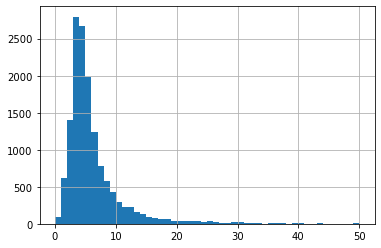

In [16]:
(data['last_price'] / 1000000).hist(bins=50, range=(0, 50))
'Цена продажи, млн руб'

Кол-во квартир дороже 30 млн резко снижается. Посмотрим на эти аномально высокие значения:

In [17]:
data = data.query('last_price < 30000000')

Есть 209 строк с аномально высокими значениями. Это меньше 1% всего датасета, но эти объекты явно не относятся к масс-маркету, и скорее могут исказить результаты исследования, нежели обогатить его.

In [18]:
#отбрасываем аномально высокие значения из датасета
data = data.query('last_price < 30000000')

Распределение значений по total_price не выглядит аномальным но есть одна квартира с аномально низкой стоимостью - 12190. Скорее всего значение внесено в тысячах руб. В следующей ячейке исправляю эту ошибку.

In [19]:
data.loc[data['last_price'] < 100000, 'last_price'] = data['last_price'] * 1000

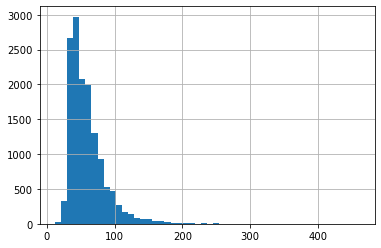

In [20]:
#анализ общей площади квартир
data['total_area'].hist(bins=50);

Площади выше 300 м удаляем как аномально высокие

In [21]:
data = data.query('total_area < 300')

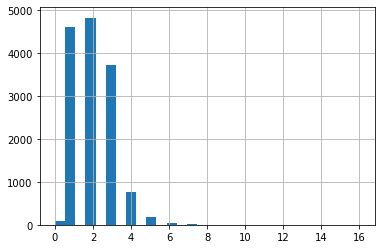

In [22]:
#анализ кол-ва комнат
data['rooms'].hist(bins=30);

In [23]:
#удаляем из датасета квартиры с аномально высоким количеством комнат - 8 и более
data = data.query('rooms < 8')

Проведем аналогичную проверку по данным living_area и kitchen_area

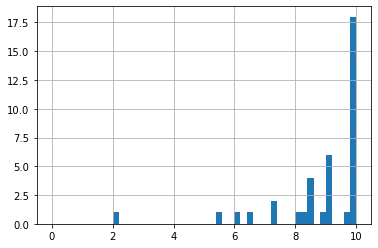

In [24]:
data['living_area'].hist(bins=50, range=(0, 10));

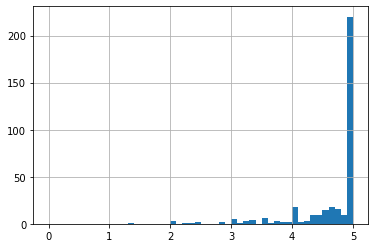

In [25]:
data['kitchen_area'].hist(bins=50, range=(0, 5));

Есть несколько квартир с жилой площадью меньше 8 кв. м. Посмотрим на строки с этими значениями.

In [26]:
print(data.query('living_area < 8'))

       total_images  last_price  total_area first_day_exposition  rooms  \
13915            20   6350000.0        52.0           2018-02-06      2   
16431            13   3799000.0        31.0           2018-04-12      1   
17961             3   1400000.0        13.0           2017-12-03      1   
19251            19   4050000.0        33.0           2018-10-15      1   
19546             3   1850000.0        13.0           2019-03-11      1   
21943            15   6100000.0        77.6           2019-02-28      4   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
13915             3.0             6     2.000000      2         False  ...   
16431             2.6             5     6.000000      1         False  ...   
17961             2.6             9     7.341952      1         False  ...   
19251             2.5            22     6.500000     21         False  ...   
19546             3.4             5     7.341952      2         False  ...   
21943 

Среди таких квартир есть миниматюрные, с площадью 13 кв. м, а есть и полноценные с площадью 52 или 77 м - скорее всего это ошибка.
Заменяю в таких ячейках данные на среднее отношение жилой площади к общей площади объекта

In [27]:
data.loc[data['living_area'] < 8, 'living_area'] = (
    data['living_area'] / data['total_area']).mean() * data['total_area']

In [28]:
#у одной квартиры значение airports_nearest = 0, что явно некорректно. Заменяю это значение на медиану
data.loc[data['airports_nearest'] < 100, 'airports_nearest'] = data['airports_nearest'].median()

### Добавление новых столбцов

In [29]:
#столбец с ценой 1 кв. метра
data['square_meter_price'] = data['last_price'] / data['total_area']

#день недели публикации объявления
data['exp_weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

#месяц публикации
data['exp_month'] = pd.DatetimeIndex(data['first_day_exposition']).month

#год публикации
data['exp_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

#тип этажа квартиры
def type_floor(row):
    floor = row['floor']
    floors_total = row['floors_total']   

    if floor == 1:
        return 'Первый'
    elif floor == floors_total:
        return 'Последний'
    return 'Другой'
 
data['type_floor'] = data.apply(type_floor, axis=1)

#расстояние до центра города в км
data['city_centers_nearest_km'] = (data['city_centers_nearest'] / 1000).round()

### Исследовательский анализ данных

#### Анализ параметров 

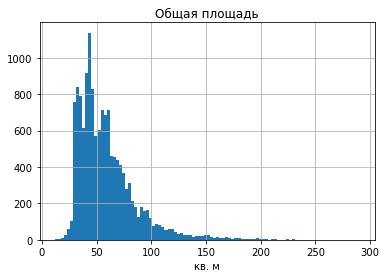

count    14250.000000
mean        59.263244
std         27.454673
min         12.000000
25%         41.000000
50%         53.000000
75%         70.000000
max        290.000000
Name: total_area, dtype: float64

In [30]:
#исследование общей площади объектов
fig, ax = plt.subplots()

data['total_area'].hist(bins=100)
ax.set_title('Общая площадь')
ax.set_xlabel('кв. м')

plt.show()

data['total_area'].describe()

Подавляющее большинство объектов имеют общую площадь в диапазоне 20-150 кв.м, самые распространенные имеют площадь 30-70 кв.м.
Гистограмма имеет 3 пика - наиболее частые площади - 30, 45 (самый высокий пик) и 60 кв. м.
Объекты с площадью более 150 м представлены в минимальном количестве.

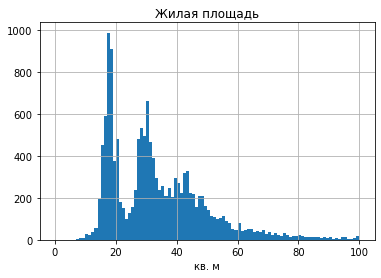

count    14250.000000
mean        34.284281
std         18.214970
min          7.407131
25%         19.350000
50%         30.448669
75%         42.900000
max        211.000000
Name: living_area, dtype: float64

In [31]:
#жилая площадь объекта
fig, ax = plt.subplots()
data['living_area'].hist(bins=100, range=(0, 100))
ax.set_title('Жилая площадь')

ax.set_xlabel('кв. м')

plt.show()

data['living_area'].describe()

У гистограммы жилых площадей также 3 пика - 18, 30 и, в меньшей степени, 43 м.
Есть единичные объекты с жилой площадью более 100 кв. м, которые исключены из гистограммы, т.к. их количество незначительно.

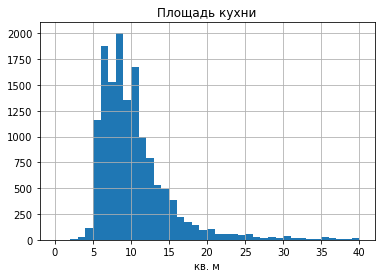

count    14250.000000
mean        10.287536
std          5.266448
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max         65.000000
Name: kitchen_area, dtype: float64

In [32]:
#площадь кухни
fig, ax = plt.subplots()
data['kitchen_area'].hist(bins=40, range=(0, 40))

ax.set_title('Площадь кухни')

ax.set_xlabel('кв. м')

plt.show()

data['kitchen_area'].describe()

У гистограммы 3 пика - 6, 8 и 10 кв.м. Большинство квартир имеют кухню с площадью в диапазоне 5-20 кв.м, есть единичные квартиры с кухнями более 40 кв.м.

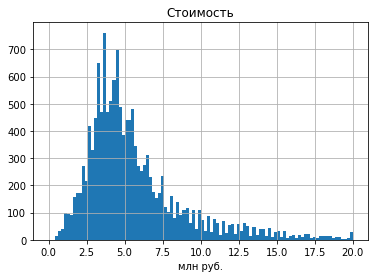

count    1.425000e+04
mean     5.968413e+06
std      4.100533e+06
min      4.500000e+05
25%      3.550000e+06
50%      4.800000e+06
75%      6.900000e+06
max      2.999900e+07
Name: last_price, dtype: float64

In [33]:
#стоимость объекта
fig, ax = plt.subplots()
(data['last_price'] / 1000000).hist(bins=100, range=(0, 20))

ax.set_title('Стоимость')

ax.set_xlabel('млн руб.')

plt.show()

data['last_price'].describe()

Наиболее распространены квартиры стоимостью 3-5 млн руб. Объектов стоимостью больше 20 млн руб в датасете представлено незначительное количество

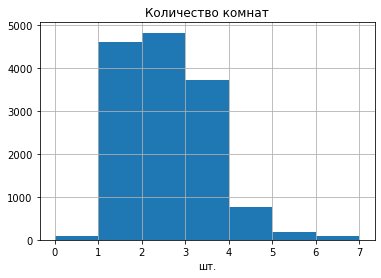

count    14250.000000
mean         2.094807
std          1.013867
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

In [34]:
#количество комнат
fig, ax = plt.subplots()
data['rooms'].hist(bins=data['rooms'].max())

ax.set_title('Количество комнат')

ax.set_xlabel('шт.')

plt.show()

data['rooms'].describe()

Больше всего квартир имеют 1-3 комнаты. Квартир премиум-сегмента с 5 и более комнатами сравнительно мало. 0 комнат - обозначение студий.

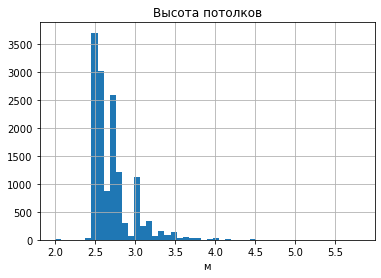

count    14250.000000
mean         2.716991
std          0.261949
min          2.000000
25%          2.500000
50%          2.650000
75%          2.800000
max          5.800000
Name: ceiling_height, dtype: float64

In [35]:
#высота потолков
fig, ax = plt.subplots()
data['ceiling_height'].hist(bins=50)

ax.set_title('Высота потолков')

ax.set_xlabel('м')

plt.show()

data['ceiling_height'].describe()

У гистограммы 3 пика: 2.5 м, 2,7 м, 3 м. Редкие отдельные квартиры могут похвастать аномально высокими потолками свыше 5 м.

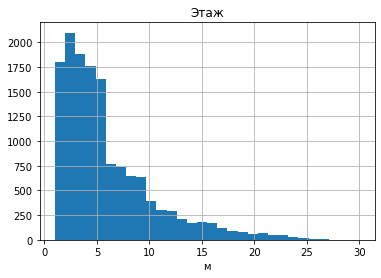

count    14250.000000
mean         5.633193
std          4.635312
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: floor, dtype: float64

In [36]:
#этаж
fig, ax = plt.subplots()
data['floor'].hist(bins=30)

ax.set_title('Этаж')

ax.set_xlabel('м')

plt.show()

data['floor'].describe()

По гистограмме видно, что больше всего объектов продается в 5-этажных домах, т.к. частота квартир этажом больше 5 резко снижается. Далее чем выше этаж, тем реже встречаются в продаже квартиры на нем.

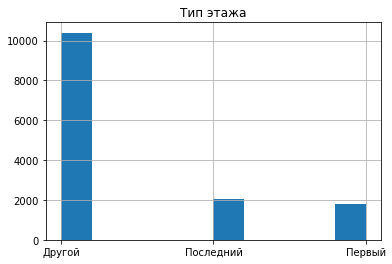

In [37]:
#тип этажа
fig, ax = plt.subplots()
data['type_floor'].hist()

ax.set_title('Тип этажа')

plt.show()

Как и ожидалось, квартир между первым и последним этажами продается намного больше, чем оных. Квартиры на последнем этаже встречаются в продаже чаще, чем на первом.

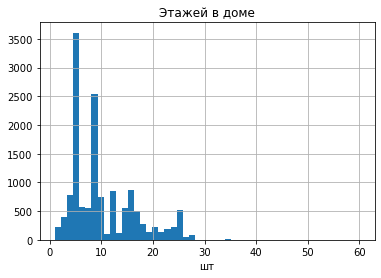

count    14250.000000
mean        10.216842
std          6.227121
min          1.000000
25%          5.000000
50%          9.000000
75%         14.000000
max         60.000000
Name: floors_total, dtype: float64

In [38]:
#кол-во этажей в доме
fig, ax = plt.subplots()
data['floors_total'].hist(bins=50)

ax.set_title('Этажей в доме')

ax.set_xlabel('шт')

plt.show()

data['floors_total'].describe()

У гистограммы 2 ярко-выраженных пика - 5 и 9 этажей. Судя по всему это отголоски страны советов, где такие дома строились по типовым проектам.

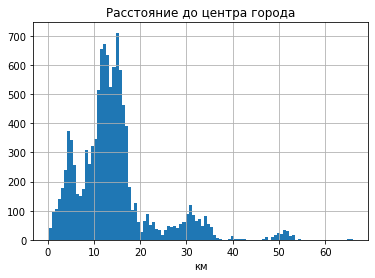

count    11316.000000
mean     14240.714740
std       8744.088683
min        208.000000
25%       9429.750000
50%      13056.000000
75%      16096.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

In [39]:
#расстояние до центра города
fig, ax = plt.subplots()
(data['city_centers_nearest'] / 1000).hist(bins=100)

ax.set_title('Расстояние до центра города')

ax.set_xlabel('км')

plt.show()

data['city_centers_nearest'].describe()

Наиболее часто встречаются квартиры на расстояниях 5, 12 и 15 км от центра города. Частота резко снижается после 17 км от центра - видимо на этом расстоянии от центра заканчивается город.

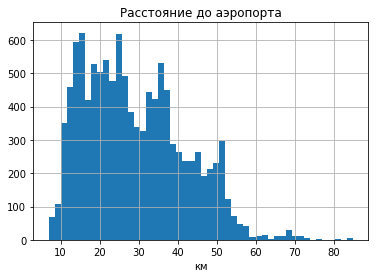

count    11299.000000
mean     28868.368086
std      12715.306405
min       6914.000000
25%      18460.500000
50%      26791.000000
75%      37310.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [40]:
#расстояние до ближайшего аэропорта
fig, ax = plt.subplots()
(data['airports_nearest'] / 1000).hist(bins=50)

ax.set_title('Расстояние до аэропорта')

ax.set_xlabel('км')

plt.show()

data['airports_nearest'].describe()

Наибольшая концентрация квартир на расстоянии 15-25 км от аэропорта. На удалении 55 км и квартир стновится резко меньше.

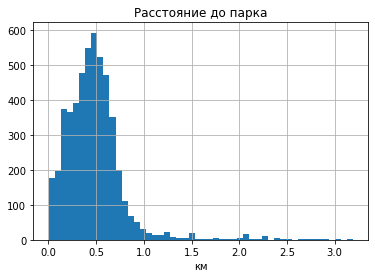

count    5111.000000
mean      479.620427
std       320.876054
min         3.000000
25%       288.000000
50%       454.000000
75%       603.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [41]:
#расстояние до ближайшего парка
fig, ax = plt.subplots()
(data['parks_nearest'] / 1000).hist(bins=50)

ax.set_title('Расстояние до парка')

ax.set_xlabel('км')

plt.show()

data['parks_nearest'].describe()

Наибольшая концентрация объектов недвижимости находится на расстоянии около 500 м от ближайшего парка и очень мало объектов дальше 1 км. По крайней мере у тех квартир, для которых этот параметр указан, т.к. в этом столбце больше 15 тыс пропусков.

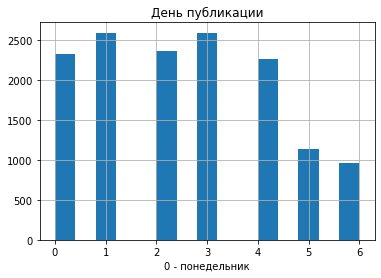

In [42]:
#день публикации
fig, ax = plt.subplots()
data['exp_weekday'].hist(bins=15)

ax.set_title('День публикации')

ax.set_xlabel('0 - понедельник')

plt.show()

Большинство объявлений публикуются в рабочие дни, чаще всего - в четверг. Воскресенье - самый "разгруженный" день

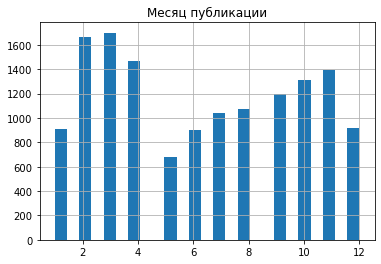

In [43]:
#месяц публикации
fig, ax = plt.subplots()
data['exp_month'].hist(bins=25)

ax.set_title('Месяц публикации')

ax.set_xlabel('')

plt.show()

Пиковый месяц по публикациям - март. Немногим отстают февраль, апрель и ноябрь. Напротив, январь, май и декабрь - самые непопулярные месяца для публикации объявлений, что логично, т.к. это и самые праздничные месяцы года.

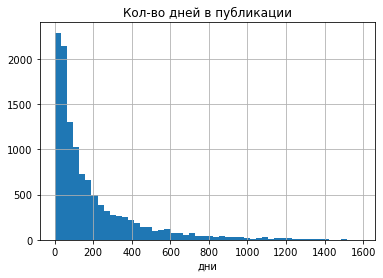

count    11870.000000
mean       188.569166
std        226.883793
min          1.000000
25%         45.000000
50%        102.000000
75%        244.750000
max       1580.000000
Name: days_exposition, dtype: float64

In [44]:
#кол-во этажей в доме
fig, ax = plt.subplots()
data['days_exposition'].hist(bins=50)

ax.set_title('Кол-во дней в публикации')

ax.set_xlabel('дни')

plt.show()

data['days_exposition'].describe()

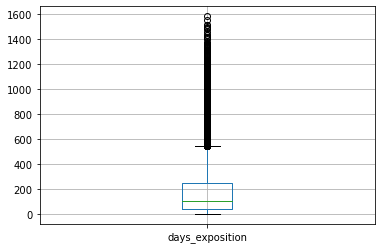

In [45]:
data_days_exp = pd.DataFrame({'days_exposition': data['days_exposition']})
data_days_exp.boxplot();

Если предположить, что снятие с публикации = продажа (что не всегда верно), то наиболее часто квартиры продаются в течение 50 дней с момента публикации. Среднее время продажи 180 дней намного превышает медианное 95 из-за небольшого количества "долгих" объявлений, рекордсмен среди которых продавался больше 4 лет.
Исходя из диаграммы размаха, продажу в течение 0-95 дней с момента публикации я бы считал быстрыми. Если квартира продается более 200 дней - объект можно считать аномально долгим.

#### Зависимость цены от разных параметров

Коэффициент корреляции 0.7928891876104226


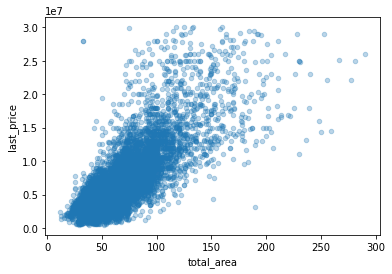

In [46]:
#зависимость цены от площади объекта. Методом query отфильтровываем аномально высокие значения
data\
.plot(x='total_area', y='last_price', kind='scatter', alpha=0.3)
print('Коэффициент корреляции', data['total_area'].corr(data['last_price']))

При цене до 4 млн и площади до 250 кв.м чем выше площадь, тем выше и цена. Для более крупных и дорогих объектов, судя по всему, площадь оказывает меньшее значение на цену.

Коэффициент корреляции 0.6915460889233973


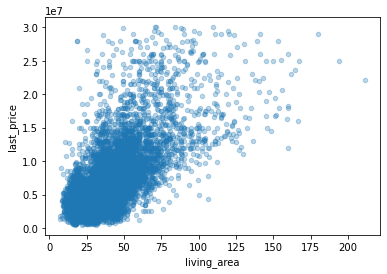

In [47]:
#зависимость цены от жилой площади. Методом query отфильтровываем аномально высокие значения
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.3)
print('Коэффициент корреляции', data['living_area'].corr(data['last_price']))

Здесь также отслеживается прямая зависимость. При цене более 20 млн и жилой площади более 100 кв.м зависимость уже не так очевидна. Скорее всего, для премиум-объектов влияние на цену оказывает намного больше параметров, чем на масс-сегмент.

Коэффициент корреляции 0.615127215047811


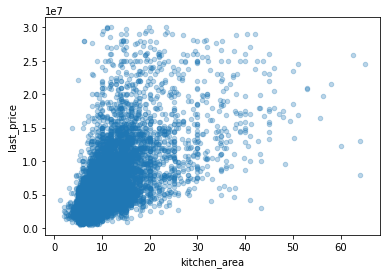

In [48]:
#зависимость цены от площади кухни. Методом query отфильтровываем аномально высокие значения
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3)
print('Коэффициент корреляции', data['kitchen_area'].corr(data['last_price']))

Здесь также отслеживается прямая зависимость, хотя и слабее, чем у общей площади. При цене более 25 млн и площади кухни более 30 кв.м зависимость слабая.

Коэффициент корреляции 0.516695401654004


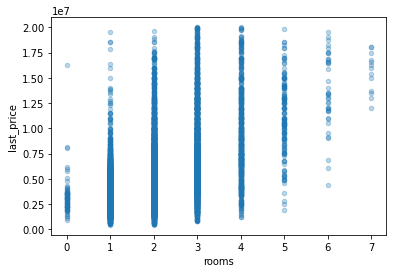

In [49]:
#зависимость цены от количества комнат. Методом query отфильтровываем аномально высокие значения
data.query('rooms < 12 and last_price < 20000000').plot(x='rooms', y='last_price', kind='scatter', alpha=0.3)
print('Коэффициент корреляции', data['rooms'].corr(data['last_price']))

Зависимость цены от количества комнат есть, но слабая, что подтверждает коэффициент корреляции. Взаимосвязь эта на уровне: дорогих однокомнатных квартир очень мало, а дешевых квартир с 5 и более комнатами нет.

last_price                         
                count          mean     median
type_floor                                    
Другой          10399  6.206586e+06  5000000.0
Первый           1806  4.750927e+06  4000000.0
Последний        2045  5.832477e+06  4500000.0

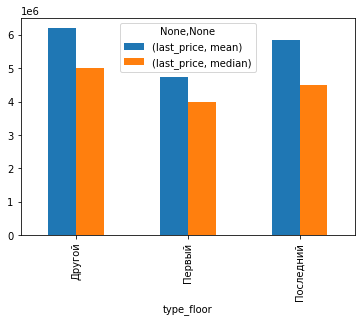

In [50]:
#зависимость цены от типа этажа
display(data.groupby('type_floor').agg({'last_price': ['count', 'mean', 'median']}))
data.groupby('type_floor').agg({'last_price': ['mean', 'median']})\
.plot(kind='bar');

Квартиры на первом этаже в-среднем ощутимо дешевле остальных. При этом средняя стоимость квартир на последнем этаже самая высокая, но их медиана ниже, чем у квартир на промежуточных этажах. Видимо, в датасете есть несколько дорогих пентхаусов на последних этажах, которые оказывают существенное влияние на среднюю цену квартир на последних этажах, но не на медиану.

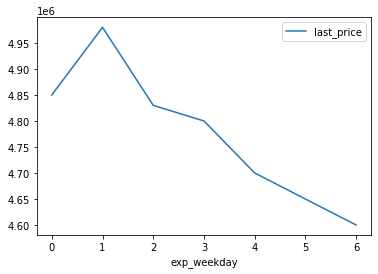

In [51]:
#зависимость цены от даты размещения объявления
data.pivot_table(index='exp_weekday', values='last_price', aggfunc='median').plot();

На графике видна некоторая связь - самые дорогие квартиры публикуют по вторникам, а далее до воскресенья медиана цен публикуемых квартир снижается.

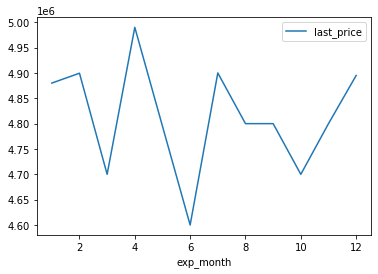

In [52]:
#зависимость цены от месяца размещения объявления
data.pivot_table(index='exp_month', values='last_price', aggfunc='median').plot();

На графике можно увидеть небольшие колебания медиан цен в зависимости от месяца. В апреле в-среднем публикуют более дорогие квартиры, в июне - менее.

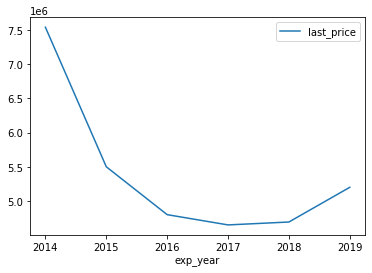

In [53]:
#зависимость цены от года размещения объявления
data.pivot_table(index='exp_year', values='last_price', aggfunc='median').plot();

На графике видно, что в 2014-2017 медианная цена публикуемых квартир снизилась с 7.5 до 4.5 млн. В 2017 медиана снова начала расти, но в 2019 все еще оставалась ниже уровня 2015 года.

Параметры, влияющие на цену квартир в порядке убывания значимости:
* общая площадь
* жилая площадь
* площадь кухни
* кол-во комнат
* этаж квартиры

**Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений**

In [54]:
data_1 = data.groupby('locality_name').agg({'square_meter_price': ['count', 'mean']})
data_1.columns = ['count', 'mean_sq_m_price']
data_2 = data_1.sort_values(by='count', ascending=False).head(10)
display(data_2)
print()
print('Населённый пункт с самой высокой стоимостью кв. метра:', data_2['mean_sq_m_price'].idxmax())
print('Населённый пункт с самой низкой стоимостью кв. метра:', data_2['mean_sq_m_price'].idxmin())

,count,mean_sq_m_price
locality_name,,
Санкт-Петербург,9856,111455.949668
Всеволожск,272,67344.467501
Пушкин,234,103920.487928
поселок Шушары,217,79538.627641
поселок Мурино,214,87138.590997
Колпино,203,75938.525561
Гатчина,148,70024.959358
Петергоф,145,85554.144673
поселок Парголово,137,90901.351145



Населённый пункт с самой высокой стоимостью кв. метра: Санкт-Петербург
Населённый пункт с самой низкой стоимостью кв. метра: Всеволожск


**Зависимость стоимости объектов Санкт-Петербурга от расстояния до центра города**

,last_price
city_centers_nearest_km,
0.0,1.197333e+07
1.0,1.230229e+07
2.0,1.146350e+07
3.0,9.676787e+06
4.0,1.082926e+07
5.0,1.090761e+07
6.0,9.734512e+06
7.0,8.820049e+06
8.0,9.220220e+06


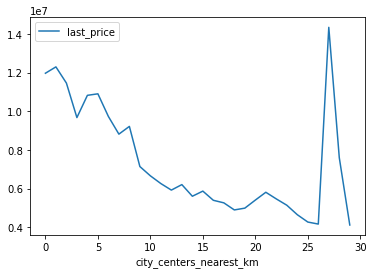

In [55]:
data_spb = data.query('locality_name == "Санкт-Петербург"')
data_spb_grouped = data_spb.groupby('city_centers_nearest_km').agg({'last_price': 'mean'})
display(data_spb_grouped)
data_spb_grouped.plot();

График в целом соответствует ожиданиям - чем ближе к центру, тем выше цена, и наоборот. Но есть 2 аномальных всплеска в 5-7 и 27 км от центра - в этих зонах средняя стоимость квартир значительно выше ожидаемой. Для полноты картины сделаем аналогичный график для средней цены 1 кв. метра.

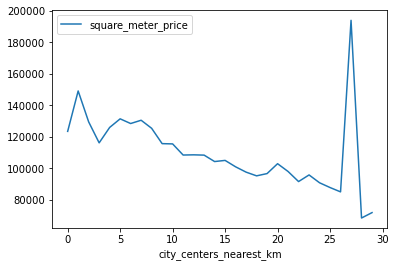

In [57]:
data_spb_grouped_sq = data_spb.groupby('city_centers_nearest_km').agg({'square_meter_price': 'mean'})
data_spb_grouped_sq.plot();

Здесь аномалии в 5-7 и, особенно, в 27 км от центра видны еще лучше. Видимо в этих зонах расположены особые, благополучные районы города.

### Общий вывод

Наиболее часто распространенные квартиры в базе данных имеют следующие параметры:
- общая площадь в диапазоне 30-70 кв.м., пиковая распространенность у 45 кв.м квартир;
- жилая площать 18 кв.м;
- площадь кухни 8 кв.м;
- стоимость 3.8 млн;
- 1 или 2 комнаты;
- высота потолков 2.5 м;
- расположена на этаже со 2 по 5;
- вероятнее всего эта квартира в 5- или 9-этажном доме
- дом находится в 12-15 км от центра города;
- расстояние до аэропорта находится в диапазоне 15-25 км;
- парка рядом с квартирой вероятнее всего нет, но если он есть, то скорее всего он в 500 м от дома.

Большинство объявлений о продаже квартир публикуются в рабочие дни, особенно в четверг, а самые активные месяцы - февраль, март, апрель и ноябрь.

Большинство квартир на сайте продается в пределах 100 дней. Если объект находится в публикации более 200 дней, то вероятно объект неликвиден, либо выставлена нерыночная цена.

В масс-сегменте квартир на цену влияют:
- площадь, как общая, так и жилая, так и площадь кухни;
- количество комнат - чем больше, тем квартира дороже;
- этаж квартиры: квартиры на 1 этаже в-среднем доступнее остальных.

День и месяц публикации на цену квартиры не влияют, но в-среднем во вторникам публикуют более дорогие объекты недвижимости, по воскресеньям - менее. Аналогично в марте публикуются более дорогие объекты, в июне - менее.

За период 2014-2019 цены на недвижимость в Петербурге менялись разнонаправленно. В 2014-2017 медианная цена публикуемых квартир снизилась с 7.5 до 4.5 млн. В 2017 медиана снова начала расти, но в 2019 все еще оставалась ниже уровня 2015 года.

Населённый пункт с самой высокой стоимостью кв. метра в Ленинградской обл. среди 10 населенных пунктов с самым большим кол-вом объявлений - Санкт-Петербург. С самой низкой - Выборг.

В Петербурге с ростом расстояния от центра города стоимость жилья снижается нелинейно - в зонах, расположенных в 5-7 и 27 км от центра стоимость как квартир, так и км.м в них значительно выше ожидаемой.